In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from scipy import stats as st
from palettable.tableau import Tableau_10

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33729,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:45603,Total threads: 4
Dashboard: /proxy/42929/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:41413,


In [3]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [4]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [5]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc').sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc').sel(time = slice('1979-01-01', '2015-01-01'))['vas']
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc').sel(time = slice('1979-01-01', '2015-01-01'))['psl']

In [6]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
path_psl = glob.glob('../data/cmip6-regridded/psl_hist*')
uas_cmip = {}; vas_cmip = {}; psl_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
    
    model_name = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0]
    psl_cmip[model_name] = xr.open_dataset(path_psl[i]).sel(time = slice('1979-01-01', '2015-01-01'))['psl']
model_keys = list(uas_cmip.keys())

In [7]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [8]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    u_ave[k] = (uas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [34]:
kat_hist = {}
for k in keys:
    kat_hist[k] = (psl[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                  psl[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')
for k in model_keys:
    kat_hist[k] = (psl_cmip[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                  psl_cmip[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

In [94]:
sam_hist = {}
for k in keys:
    sam_hist[k] = (psl[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                   psl[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')
for k in model_keys:
    sam_hist[k] = (psl_cmip[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                   psl_cmip[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

# Time series historical period

## KAT Index

In [16]:
kat_idx = {}
for k in keys:
    kat_idx[k] = (psl[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                  psl[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')
for k in model_keys:
    kat_idx[k] = (psl_cmip[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                  psl_cmip[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

In [17]:
r_u_kat = {}
for k in keys:
    r_u_kat[k] = st.linregress(kat_idx[k], -u_ave[k]).rvalue

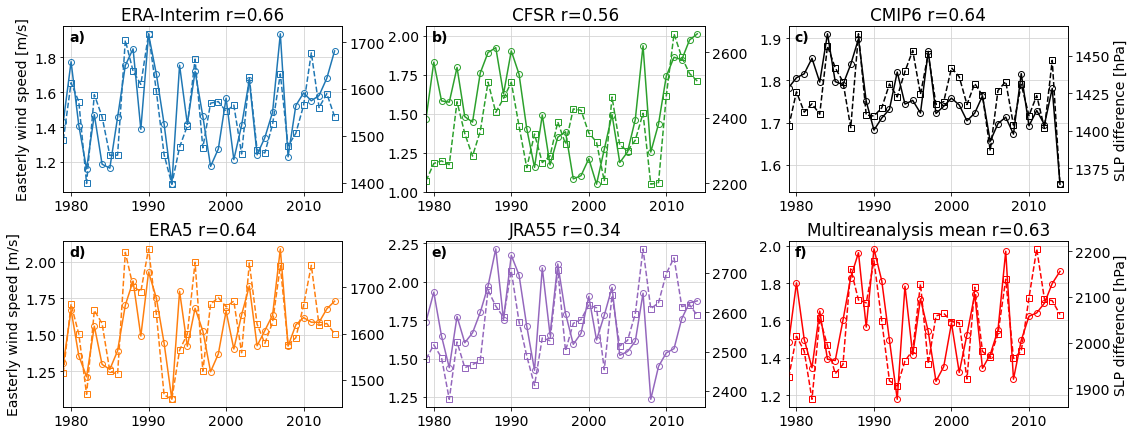

In [18]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18,7))
gr = gs.GridSpec(2, 3, figure = fig, hspace = 0.3, wspace = 0.3)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[0,2]),
       fig.add_subplot(gr[1,2])]
for ax, label in zip(axs, ['a)', 'd)', 'b)', 'e)', 'c)', 'f)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.text(0.02, .91, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xticks(np.arange(1980, 2020, 10))
    ax.set_xlim(1979, 2015)
        
n = 0
for k, cl in zip(keys, [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4], 'k', 'r']):
    axs[n].plot(u_ave[k]['year'], -u_ave[k], color = cl, marker = 'o', markerfacecolor = 'none')
    axk = axs[n].twinx()
    axk.plot(kat_idx[k]['year'], kat_idx[k], color = cl, marker = 's', markerfacecolor = 'none', linestyle = '--')
    if n in [0, 1]:
        axs[n].set_ylabel('Easterly wind speed [m/s]')
    elif n in [4, 5]:
        axk.set_ylabel('SLP difference [hPa]')
                      
    n += 1
axs[0].set_title('ERA-Interim r='+str(np.round(r_u_kat['erai'], 2)))
axs[1].set_title('ERA5 r='+str(np.round(r_u_kat['era5'], 2)))
axs[2].set_title('CFSR r='+str(np.round(r_u_kat['cfsr'], 2)))
axs[3].set_title('JRA55 r='+str(np.round(r_u_kat['jra55'], 2)))
axs[4].set_title('CMIP6 r='+str(np.round(r_u_kat['cmip6'], 2)))
axs[5].set_title('Multireanalysis mean r='+str(np.round(r_u_kat['reanalysis'], 2)))

plt.savefig('../results/v5/uas_vs_katidx_reanalysis.jpg', bbox_inches = 'tight')

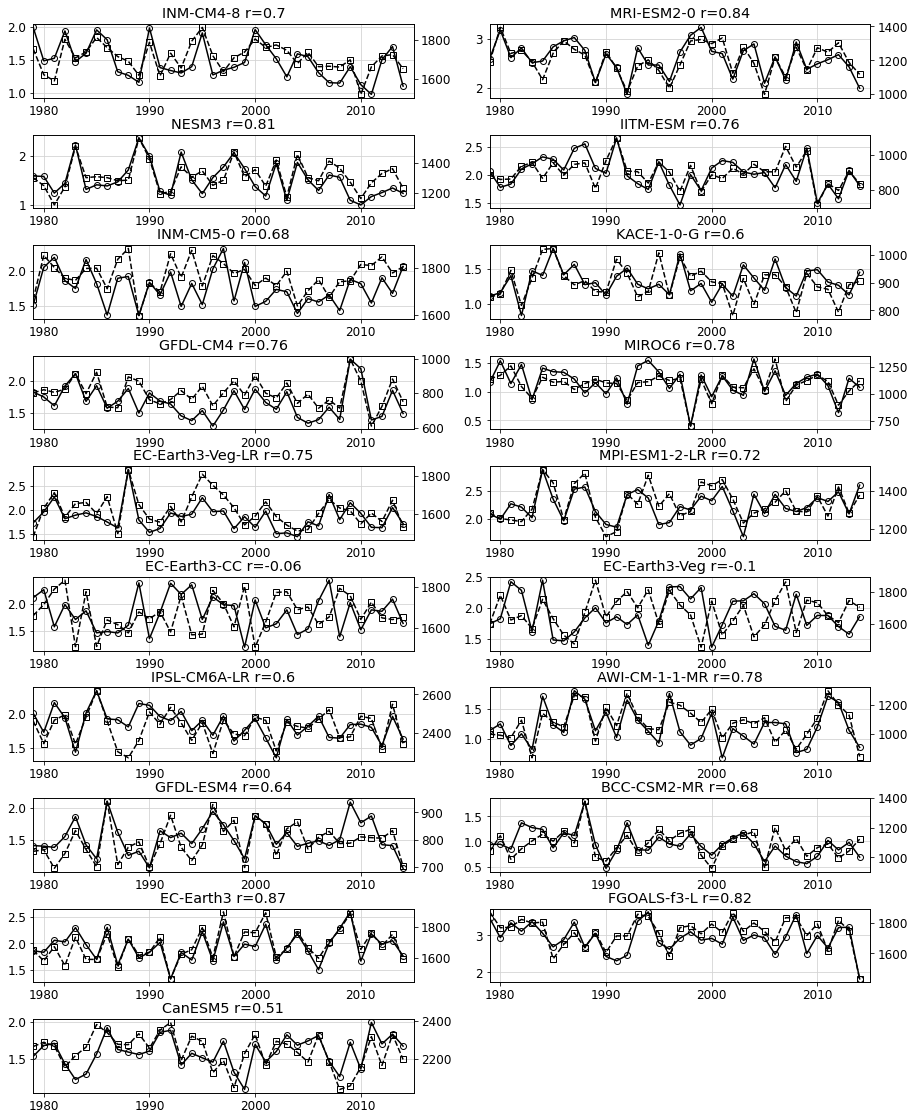

In [20]:
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize = (15, 40))
gr = gs.GridSpec(20, 2, figure = fig, hspace = .5, wspace = 0.2)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0])]
for ax, label in zip(axs, model_keys):
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.set_xticks(np.arange(1980, 2020, 10))
    ax.set_xlim(1979, 2015)
        
n = 0
for k in model_keys:
    axs[n].plot(u_ave[k]['year'], -u_ave[k], color = 'k', marker = 'o', markerfacecolor = 'none')
    axk = axs[n].twinx()
    axk.plot(kat_idx[k]['year'], kat_idx[k], color = 'k', marker = 's', markerfacecolor = 'none', linestyle = '--')
    r = st.linregress(kat_idx[k], -u_ave[k]).rvalue
    axs[n].set_title(k +' r='+str(np.round(r, 2)))
    n += 1

plt.savefig('../results/v5/uas_vs_katidx_cmip6ind.jpg', bbox_inches = 'tight')

In [28]:
wsp = {}; wsp_ave = {}
for k in keys:
    wsp[k] = np.sqrt(uas[k]**2 + vas[k]**2)
    wsp_ave[k] = (wsp[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    wsp[k] = np.sqrt(uas_cmip[k]**2 + vas_cmip[k]**2)
    wsp_ave[k] = (wsp[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [29]:
r_ws_kat = {}
for k in keys:
    r_ws_kat[k] = st.linregress(kat_idx[k], wsp_ave[k]).rvalue

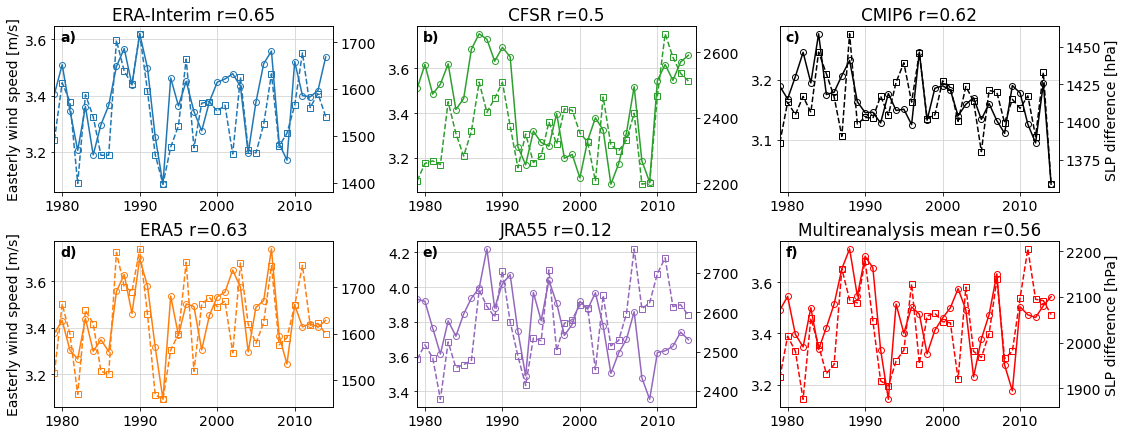

In [30]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18,7))
gr = gs.GridSpec(2, 3, figure = fig, hspace = 0.3, wspace = 0.3)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[0,2]),
       fig.add_subplot(gr[1,2])]
for ax, label in zip(axs, ['a)', 'd)', 'b)', 'e)', 'c)', 'f)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.text(0.02, .91, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xticks(np.arange(1980, 2020, 10))
    ax.set_xlim(1979, 2015)
        
n = 0
for k, cl in zip(keys, [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4], 'k', 'r']):
    axs[n].plot(u_ave[k]['year'], wsp_ave[k], color = cl, marker = 'o', markerfacecolor = 'none')
    axk = axs[n].twinx()
    axk.plot(kat_idx[k]['year'], kat_idx[k], color = cl, marker = 's', markerfacecolor = 'none', linestyle = '--')
    if n in [0, 1]:
        axs[n].set_ylabel('Easterly wind speed [m/s]')
    elif n in [4, 5]:
        axk.set_ylabel('SLP difference [hPa]')
                      
    n += 1
axs[0].set_title('ERA-Interim r='+str(np.round(r_ws_kat['erai'], 2)))
axs[1].set_title('ERA5 r='+str(np.round(r_ws_kat['era5'], 2)))
axs[2].set_title('CFSR r='+str(np.round(r_ws_kat['cfsr'], 2)))
axs[3].set_title('JRA55 r='+str(np.round(r_ws_kat['jra55'], 2)))
axs[4].set_title('CMIP6 r='+str(np.round(r_ws_kat['cmip6'], 2)))
axs[5].set_title('Multireanalysis mean r='+str(np.round(r_ws_kat['reanalysis'], 2)))

plt.savefig('../results/v5/wsp_vs_katidx_reanalysis.jpg', bbox_inches = 'tight')

## SAM Index

In [22]:
sam_idx = {}
for k in keys:
    sam_idx[k] = (psl[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                  psl[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')
for k in model_keys:
    sam_idx[k] = (psl_cmip[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                  psl_cmip[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

In [23]:
r_u_sam = {}
for k in keys:
    r_u_sam[k] = st.linregress(sam_idx[k], -u_ave[k]).rvalue

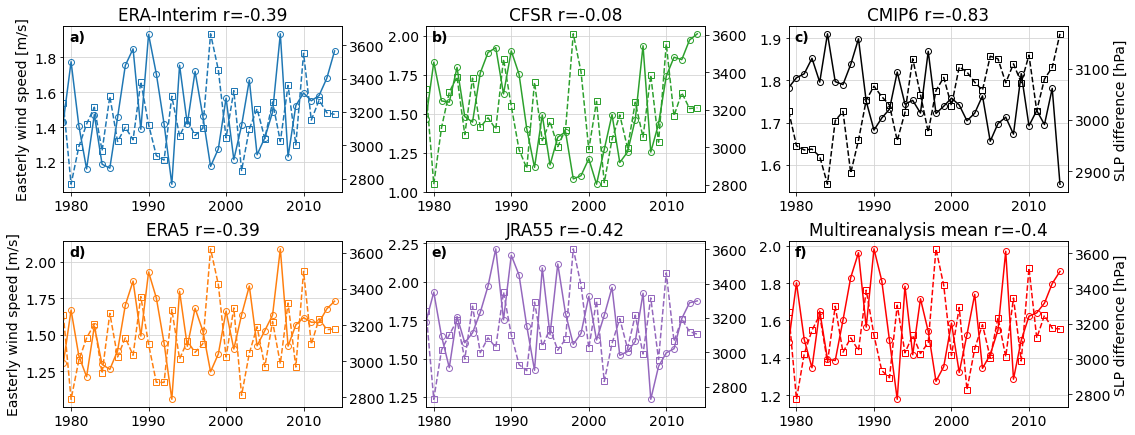

In [25]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18,7))
gr = gs.GridSpec(2, 3, figure = fig, hspace = 0.3, wspace = 0.3)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[0,2]),
       fig.add_subplot(gr[1,2])]
for ax, label in zip(axs, ['a)', 'd)', 'b)', 'e)', 'c)', 'f)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.text(0.02, .91, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xticks(np.arange(1980, 2020, 10))
    ax.set_xlim(1979, 2015)
        
n = 0
for k, cl in zip(keys, [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4], 'k', 'r']):
    axs[n].plot(u_ave[k]['year'], -u_ave[k], color = cl, marker = 'o', markerfacecolor = 'none')
    axk = axs[n].twinx()
    axk.plot(sam_idx[k]['year'], sam_idx[k], color = cl, marker = 's', markerfacecolor = 'none', linestyle = '--')
    if n in [0, 1]:
        axs[n].set_ylabel('Easterly wind speed [m/s]')
    elif n in [4, 5]:
        axk.set_ylabel('SLP difference [hPa]')
                      
    n += 1
axs[0].set_title('ERA-Interim r='+str(np.round(r_u_sam['erai'], 2)))
axs[1].set_title('ERA5 r='+str(np.round(r_u_sam['era5'], 2)))
axs[2].set_title('CFSR r='+str(np.round(r_u_sam['cfsr'], 2)))
axs[3].set_title('JRA55 r='+str(np.round(r_u_sam['jra55'], 2)))
axs[4].set_title('CMIP6 r='+str(np.round(r_u_sam['cmip6'], 2)))
axs[5].set_title('Multireanalysis mean r='+str(np.round(r_u_sam['reanalysis'], 2)))

plt.savefig('../results/v5/uas_vs_samidx_reanalysis.jpg', bbox_inches = 'tight')

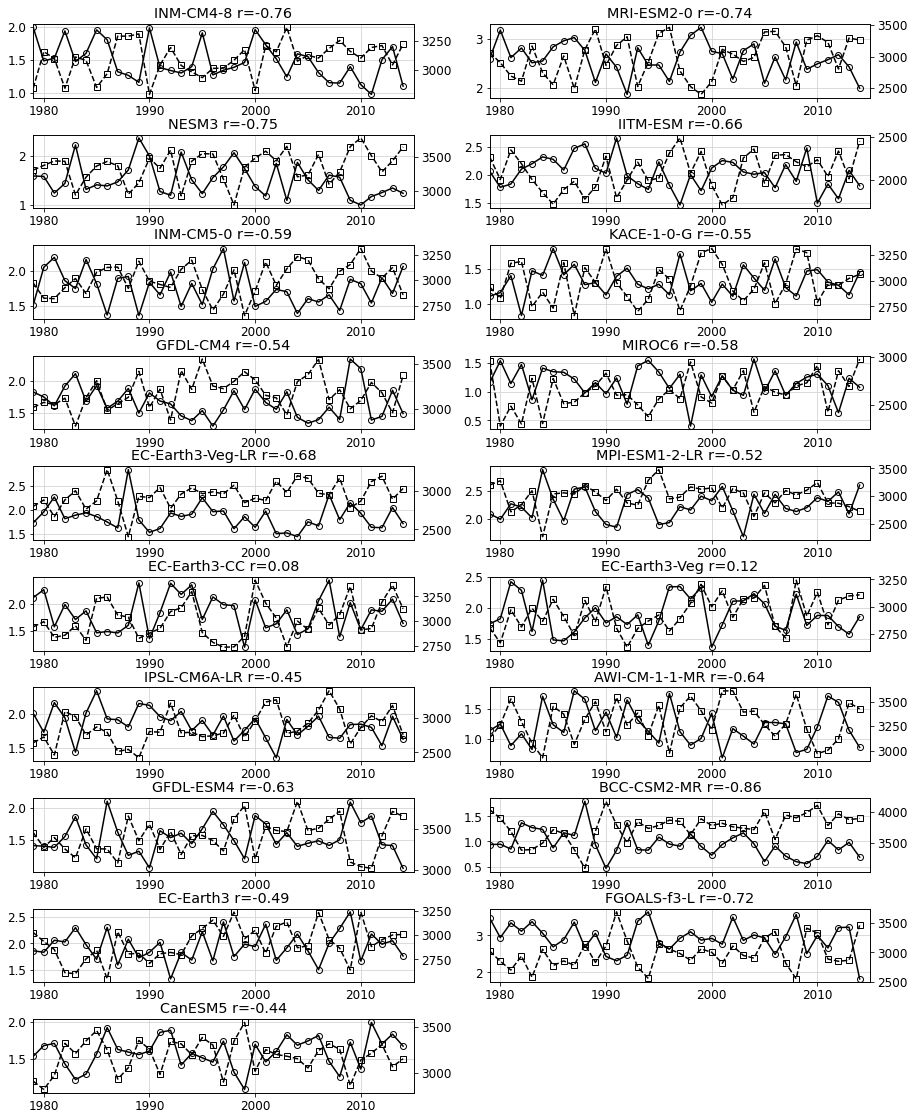

In [26]:
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize = (15, 40))
gr = gs.GridSpec(20, 2, figure = fig, hspace = .5, wspace = 0.2)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0])]
for ax, label in zip(axs, model_keys):
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.set_xticks(np.arange(1980, 2020, 10))
    ax.set_xlim(1979, 2015)
        
n = 0
for k in model_keys:
    axs[n].plot(u_ave[k]['year'], -u_ave[k], color = 'k', marker = 'o', markerfacecolor = 'none')
    axk = axs[n].twinx()
    axk.plot(sam_idx[k]['year'], sam_idx[k], color = 'k', marker = 's', markerfacecolor = 'none', linestyle = '--')
    r = st.linregress(sam_idx[k], -u_ave[k]).rvalue
    axs[n].set_title(k +' r='+str(np.round(r, 2)))
    n += 1

plt.savefig('../results/v5/uas_vs_samidx_cmip6ind.jpg', bbox_inches = 'tight')

# SSP45

In [19]:
uas_ssp45 = {}
vas_ssp45 = {}
psl_ssp45 = {}
uas_ssp45['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc').sel(time = slice('2015-01-01', '2100-01-01'))['uas']
vas_ssp45['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc').sel(time = slice('2015-01-01', '2100-01-01'))['vas']
psl_ssp45['cmip6'] = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp45.nc').sel(time = slice('2015-01-01', '2100-01-01'))['psl']

In [20]:
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp4.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp4.5*')
path_psl = glob.glob('../data/cmip6-regridded/psl_ssp4.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp45[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('2015-01-01', '2100-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp45[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('2015-01-01', '2100-01-01'))['vas']
    
    model_name = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    psl_ssp45[model_name] = xr.open_dataset(path_psl[i]).sel(time = slice('2015-01-01', '2100-01-01'))['psl']
model_keys = list(uas_cmip.keys())

In [25]:
u_ave_ssp45 = {}
v_ave_ssp45 = {}
for k in keys[-1:]:
    u_ave_ssp45[k] = (uas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp45[k] = (vas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    u_ave_ssp45[k] = (uas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp45[k] = (vas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [36]:
kat_ssp45 = {}
for k in keys[-1:]+model_keys:
    kat_ssp45[k] = (psl_ssp45[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                    psl_ssp45[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

In [95]:
sam_ssp45 = {}
for k in keys[-1:]+model_keys:
    sam_ssp45[k] = (psl_ssp45[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                    psl_ssp45[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

## SSP85

In [26]:
uas_ssp85 = {}
vas_ssp85 = {}
psl_ssp85 = {}
uas_ssp85['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc').sel(time = slice('2015-01-01', '2100-01-01'))['uas']
vas_ssp85['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc').sel(time = slice('2015-01-01', '2100-01-01'))['vas']
psl_ssp85['cmip6'] = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc').sel(time = slice('2015-01-01', '2100-01-01'))['psl']

In [39]:
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp8.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp8.5*')
path_psl = glob.glob('../data/cmip6-regridded/psl_ssp8.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp85[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('2015-01-01', '2100-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp85[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('2015-01-01', '2100-01-01'))['vas']
    
    model_name = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0]
    psl_ssp85[model_name] = xr.open_dataset(path_psl[i]).sel(time = slice('2015-01-01', '2100-01-01'))['psl']
model_keys = list(uas_cmip.keys())

In [28]:
u_ave_ssp85 = {}
v_ave_ssp85 = {}
for k in keys[-1:]:
    u_ave_ssp85[k] = (uas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp85[k] = (vas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    u_ave_ssp85[k] = (uas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp85[k] = (vas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [40]:
kat_ssp85 = {}
for k in keys[-1:]+model_keys:
    kat_ssp85[k] = (psl_ssp85[k].groupby('time.year').mean('time').sel(lat = -85, method = 'nearest') - \
                    psl_ssp85[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

In [96]:
sam_ssp85 = {}
for k in keys[-1:]+model_keys:
    sam_ssp85[k] = (psl_ssp85[k].groupby('time.year').mean('time').sel(lat = -40, method = 'nearest') - \
                    psl_ssp85[k].groupby('time.year').mean('time').sel(lat = -65, method = 'nearest')).mean('lon')

## Correlation matrix

In [138]:
import matplotlib.colors as mcolors

In [172]:
norm = mcolors.BoundaryNorm(np.arange(-1, 1.1, .1), ncolors = 256)

In [173]:
corr_matrix = xr.DataArray(np.zeros([6, 25])*np.nan, dims = ['period', 'model'], coords = {'period':np.arange(0,6,1), 'model':keys+model_keys})
significance = corr_matrix.copy()

In [174]:
for k in keys+model_keys:
    LR = st.linregress(kat_hist[k], -u_ave[k])
    corr_matrix = xr.where((corr_matrix['period']==0) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
    significance = xr.where((significance['period']==0) & (significance['model']==k), LR.pvalue, significance)
    
    LR = st.linregress(sam_hist[k], -u_ave[k])
    corr_matrix = xr.where((corr_matrix['period']==3) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
    significance = xr.where((significance['period']==3) & (significance['model']==k), LR.pvalue, significance)
    
    if k not in keys[:-1]:
        LR = st.linregress(kat_ssp45[k], -u_ave_ssp45[k])
        corr_matrix = xr.where((corr_matrix['period']==1) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==1) & (significance['model']==k), LR.pvalue, significance)
        
        LR = st.linregress(sam_ssp45[k], -u_ave_ssp45[k])
        corr_matrix = xr.where((corr_matrix['period']==4) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==4) & (significance['model']==k), LR.pvalue, significance)

        LR = st.linregress(kat_ssp85[k], -u_ave_ssp85[k])
        corr_matrix = xr.where((corr_matrix['period']==2) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==2) & (significance['model']==k), LR.pvalue, significance)
        
        LR = st.linregress(sam_ssp85[k], -u_ave_ssp85[k])
        corr_matrix = xr.where((corr_matrix['period']==5) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==5) & (significance['model']==k), LR.pvalue, significance)

In [175]:
corr_matrix.sel(model = 'cmip6')

<xarray.DataArray (period: 6)>
array([ 0.64254835,  0.77783807,  0.93324072, -0.82617531, -0.81697337,
       -0.92912544])
Coordinates:
  * period   (period) int64 0 1 2 3 4 5
    model    <U16 'cmip6'

In [176]:
p_masked = np.ma.masked_where(significance.values >= 0.05, significance.values)

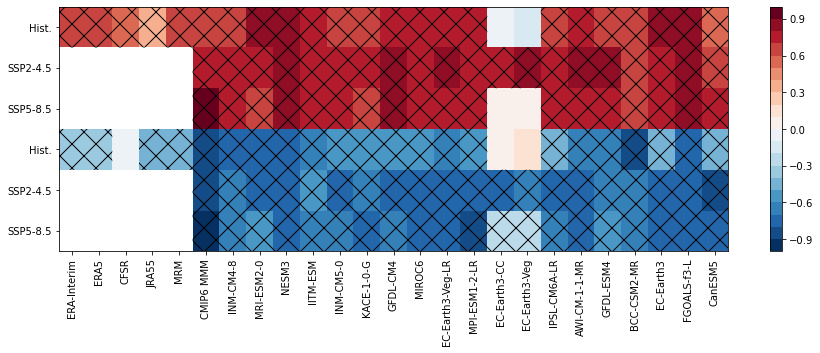

In [178]:
plt.figure(figsize = (15, 4.5))
plt.pcolormesh(corr_matrix['model'], -corr_matrix['period'], corr_matrix, norm = norm, cmap = 'RdBu_r')
plt.xticks(np.arange(25), ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'MRM', 'CMIP6 MMM']+list(corr_matrix['model'][6:].values), rotation = 90);
plt.yticks(np.arange(-5,1,1), ['SSP5-8.5', 'SSP2-4.5', 'Hist.', 'SSP5-8.5', 'SSP2-4.5', 'Hist.']);
plt.colorbar()
plt.pcolor(corr_matrix['model'], -corr_matrix['period'], p_masked, hatch='x', alpha = 0)
plt.savefig('../results/v6/r_matrix_samkat.jpg', bbox_inches = 'tight')

In [181]:
corr_matrix = xr.DataArray(np.zeros([6, 25])*np.nan, dims = ['period', 'model'], coords = {'period':np.arange(0,6,1), 'model':keys+model_keys})
significance = corr_matrix.copy()

In [182]:
for k in keys+model_keys:
    LR = st.linregress(kat_hist[k], v_ave[k])
    corr_matrix = xr.where((corr_matrix['period']==0) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
    significance = xr.where((significance['period']==0) & (significance['model']==k), LR.pvalue, significance)
    
    LR = st.linregress(sam_hist[k], v_ave[k])
    corr_matrix = xr.where((corr_matrix['period']==3) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
    significance = xr.where((significance['period']==3) & (significance['model']==k), LR.pvalue, significance)
    
    if k not in keys[:-1]:
        LR = st.linregress(kat_ssp45[k], v_ave_ssp45[k])
        corr_matrix = xr.where((corr_matrix['period']==1) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==1) & (significance['model']==k), LR.pvalue, significance)
        
        LR = st.linregress(sam_ssp45[k], v_ave_ssp45[k])
        corr_matrix = xr.where((corr_matrix['period']==4) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==4) & (significance['model']==k), LR.pvalue, significance)

        LR = st.linregress(kat_ssp85[k], v_ave_ssp85[k])
        corr_matrix = xr.where((corr_matrix['period']==2) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==2) & (significance['model']==k), LR.pvalue, significance)
        
        LR = st.linregress(sam_ssp85[k], v_ave_ssp85[k])
        corr_matrix = xr.where((corr_matrix['period']==5) & (corr_matrix['model']==k), LR.rvalue, corr_matrix)
        significance = xr.where((significance['period']==5) & (significance['model']==k), LR.pvalue, significance)

In [183]:
p_masked = np.ma.masked_where(significance.values >= 0.05, significance.values)

In [184]:
corr_matrix.sel(model = 'cmip6')

<xarray.DataArray (period: 6)>
array([ 0.57830869,  0.69722521,  0.88644788, -0.60473629, -0.64582179,
       -0.90121715])
Coordinates:
  * period   (period) int64 0 1 2 3 4 5
    model    <U16 'cmip6'

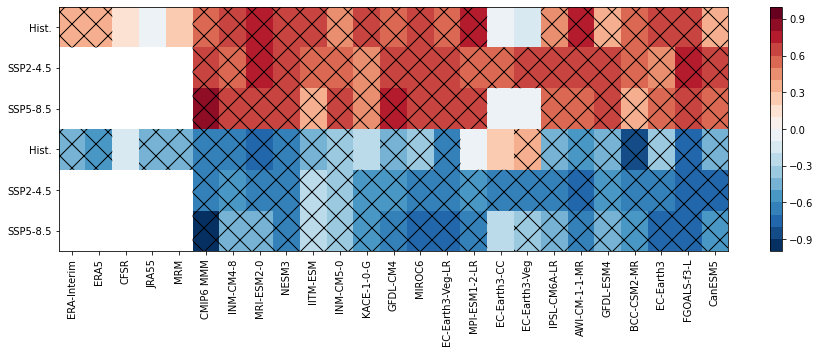

In [185]:
plt.figure(figsize = (15, 4.5))
plt.pcolormesh(corr_matrix['model'], -corr_matrix['period'], corr_matrix, norm = norm, cmap = 'RdBu_r')
plt.xticks(np.arange(25), ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'MRM', 'CMIP6 MMM']+list(corr_matrix['model'][6:].values), rotation = 90);
plt.yticks(np.arange(-5,1,1), ['SSP5-8.5', 'SSP2-4.5', 'Hist.', 'SSP5-8.5', 'SSP2-4.5', 'Hist.']);
plt.colorbar()
plt.pcolor(corr_matrix['model'], -corr_matrix['period'], p_masked, hatch='x', alpha = 0)
plt.savefig('../results/v6/r_matrix_samkat_vas.jpg', bbox_inches = 'tight')

In [159]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

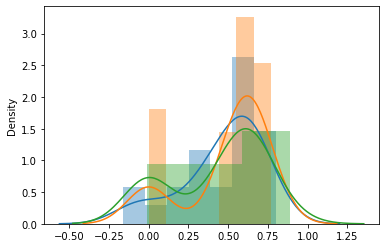

In [163]:
sns.distplot(corr_matrix.sel(period=0))
sns.distplot(corr_matrix.sel(period=1))
sns.distplot(corr_matrix.sel(period=2))

<AxesSubplot:ylabel='Density'>

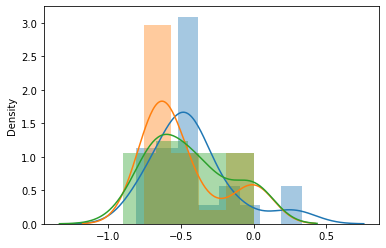

In [164]:
sns.distplot(corr_matrix.sel(period=3))
sns.distplot(corr_matrix.sel(period=4))
sns.distplot(corr_matrix.sel(period=5))